# Neural Network Approach for Document Categorization

use bi-directional LSTM with self attention

In [1]:
import re 
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Gensim
import gensim
# # pytorch 
import torch
import torch.nn as nn
import torch.optim as optim

[nltk_data] Downloading package stopwords to /home/sxia1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## given a corpus clean each text in the collection

In [2]:
#helper function for lemmatization
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n' #if not belong to any, default is noun, inclunding N

def lemmatize_with_pos(abstract_toekenized):
    abstract_tagged = nltk.pos_tag(abstract_toekenized)
    tags = list(map(lambda token: get_wordnet_pos(token[1]),abstract_tagged))
    abstract_lemmatized = list(map(lemmatizer.lemmatize,abstract_toekenized,tags))
    return abstract_lemmatized


#import nltk lemmatizer
lemmatizer = WordNetLemmatizer()

def prepare_token(text_tokenized_list,bigram):
    # remove stopwords and puntuation, 
    text_stopwords_removed = list(map(lambda abstract: list(filter(lambda word: word not in stop_words, abstract)),text_tokenized_list))

    #apply biagram model
    word_and_bigram_list = list(map(lambda abstract_cleaned: bigram[abstract_cleaned],text_stopwords_removed))

    # lemmatize
    abstract_lemmatized = list(map(lemmatize_with_pos,word_and_bigram_list))
    return abstract_lemmatized

def tokenize_prepare(df,update_bigram = False,**kwargs):
    # remove puncutations and number, then tokenize each text
    text_tokenized = list(map(lambda abstract_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',abstract_i.lower())), df.Abstract))
    len(text_tokenized)
    df['n_words']=list(map(lambda x:len(x),text_tokenized))

    # Creating Bigram: find words frequently occur together
    if update_bigram:
        bigram = gensim.models.Phrases(text_tokenized, min_count=20, threshold=50) 
    else:
        bigram = kwargs.get('bigram',None) 
    #come back to adjust the threshold value: (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold
    # bigram_freeze = bigram.freeze()
    abstract_lemmatized = prepare_token(text_tokenized,bigram)
    df['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))
    # plot data
    fig,axs = plt.subplots(1,4,figsize=(25,5))
    categories = df.Domain.value_counts().index
    counts = df.Domain.value_counts().values
    axs[0].bar(categories, counts, width=0.5)
    axs[0].set_title("Domain Frquency")
    categories = df.area.value_counts().index
    counts = df.area.value_counts().values
    axs[1].bar(categories, counts, width=0.5)
    axs[1].set_title("Area Frquency")
    axs[2].hist(df.n_words)
    axs[2].set_title("abstract word count")
    axs[3].hist(df.n_words_removed,bins=30)
    axs[3].set_title("abstract without stop words word count")

    plt.show()
    return abstract_lemmatized,df,bigram



46985
['CS ' 'Medical ' 'Civil ' 'ECE ' 'biochemistry ' 'MAE ' 'Psychology  ']
{'CS ': 0, 'Medical ': 1, 'Civil ': 2, 'ECE ': 3, 'biochemistry ': 4, 'MAE ': 5, 'Psychology  ': 6}


/tmp/ipykernel_22213/2335753809.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['Domain_No'] = df_paper.Domain.map(topic2num)
/tmp/ipykernel_22213/3826879653.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_words']=list(map(lambda x:len(x),text_tokenized))
/tmp/ipykernel_22213/3826879653.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

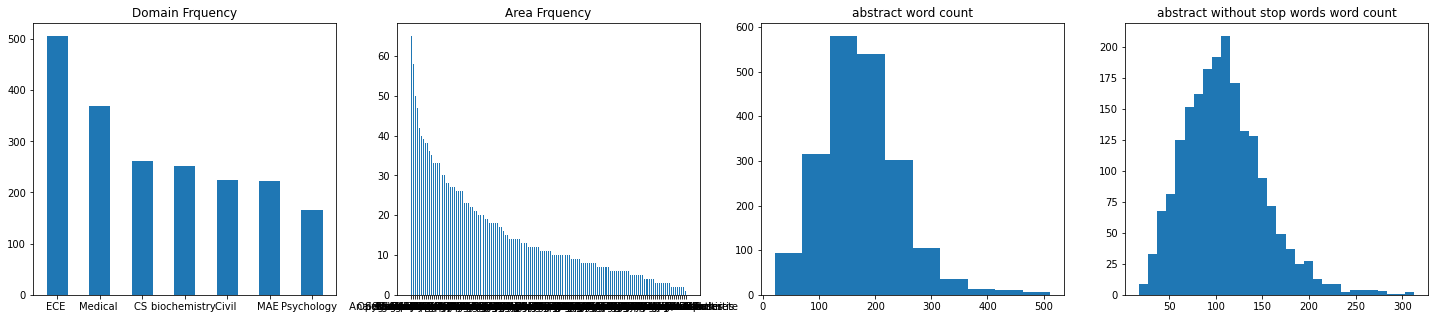

In [7]:
stop_words = stopwords.words('english')
# read-in pre-labled research apper abstracts
df_paper_raw = pd.read_excel("data/WebOfScienceData.xlsx",sheet_name="abstracts")
print(len(df_paper_raw))
df_paper = df_paper_raw.head(2000) #use first 2000
print(df_paper.Domain.unique())
topic2num = {topic:i for i,topic in enumerate(df_paper.Domain.unique())}
print(topic2num)
df_paper['Domain_No'] = df_paper.Domain.map(topic2num)

abstract_lemmatized, df,bigram = tokenize_prepare(df_paper,update_bigram=True)



['use', 'model', 'system', 'study', 'method', 'propose', 'result', 'control', 'present', 'base', 'show', 'design', 'analysis', 'high', 'cell', 'data', 'also', 'patient', 'effect', 'increase', 'two', 'different', 'time', 'develop', 'process', 'provide', 'new', 'paper', 'include', 'rights_reserved', 'approach', 'compare', 'performance', 'test', 'algorithm', 'level', 'low', 'c_elsevier', 'power', 'measure', 'well', 'structure', 'condition', 'energy', 'find', 'function', 'one', 'may', 'parameter', 'application', 'simulation', 'current', 'obtain', 'group', 'change']


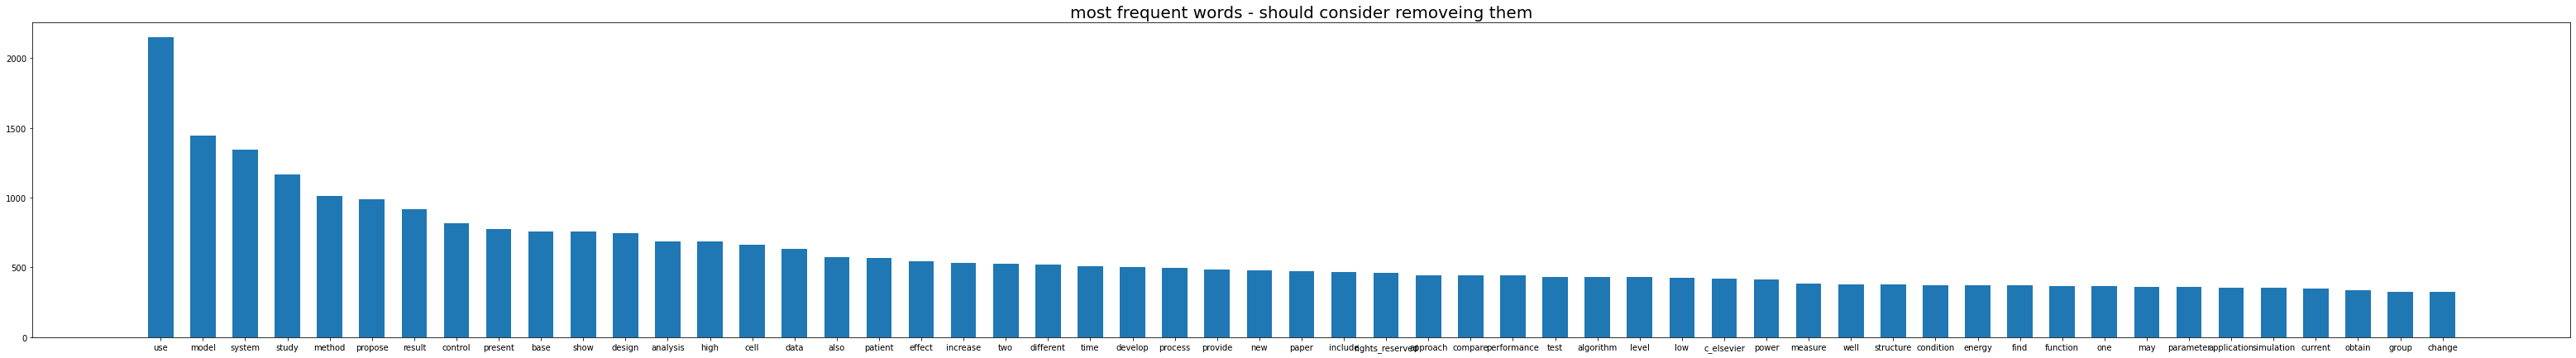

['well', 'structure', 'condition', 'energy', 'find', 'function', 'one', 'may', 'parameter', 'application', 'simulation', 'current', 'obtain', 'group', 'change', 'frequency', 'dynamic', 'circuit', 'improve', 'expression']


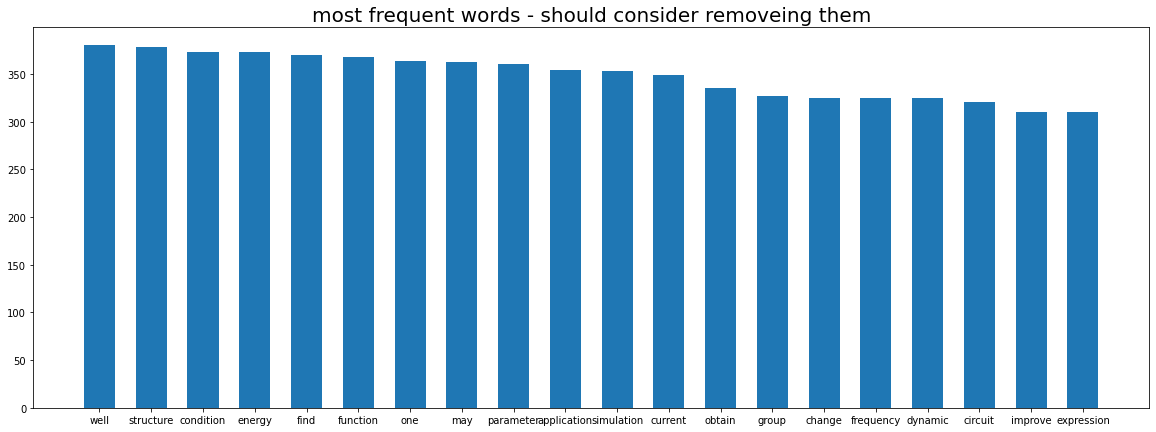

/tmp/ipykernel_22213/3453406941.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))


Text(200, 150, 'median length: 91')

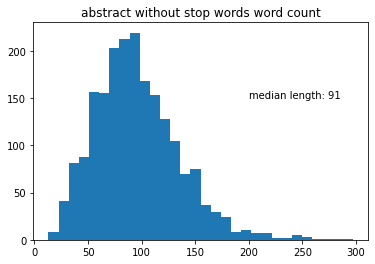

In [8]:
# remove popular words??
def check_frequent_words(corpus,top_n):
    all_corpus_together=np.concatenate(corpus)
    (word, counts) = np.unique(all_corpus_together, return_counts=True)
    frequencies = np.asarray((word, counts)).T
    count_df = pd.DataFrame(data=frequencies,columns = ['word','freq'])
    count_df.freq = count_df.freq.astype(int)
    count_df.sort_values(by=['freq'],axis=0,ascending=False,ignore_index=True,inplace=True)
    print(list(count_df.head(top_n).word))
    plt.figure(figsize=(top_n,7))
    plt.bar(count_df[:top_n].word,height=count_df[:top_n].freq,width=0.6,align='center')
    plt.title("most frequent words - should consider removeing them",fontsize=20)
    plt.show()
    return count_df

count_df =check_frequent_words(abstract_lemmatized,55)

# remove top 50 most frequent words
top_n = list(count_df[:40].word)
abstract_lemmatized_cleaned = list(map(lambda abstract: list(filter(lambda word: word not in top_n, abstract)),abstract_lemmatized))
check_frequent_words(abstract_lemmatized_cleaned,top_n=20)
df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))
median_count = np.median(df_paper.n_words_lemmatize_clean)
plt.hist(df_paper.n_words_lemmatize_clean,bins=30)
plt.title("abstract without stop words word count")
plt.text(200,150,"median length: %d"%median_count,fontsize=10)

In [6]:
list(map(lambda x:len(x),abstract_lemmatized_cleaned))

[86, 126, 67, 76, 113, 107, 80, 78, 122, 111]

## Building our Nerual Network
1. define and train word2vec from Gensim
2. apply word2vec on our documents 
3. input to the nerual network: vectorized document using word2vec
4. output: distribution of topics (a vector with length = # topics)

5. cross entropy function:

In [4]:
import gensim.downloader
from gensim.models import Word2Vec

glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [14]:
print(np.shape(glove_vectors['medicine']))
print(np.shape(glove_vectors['water']))
#word vector/input dim = 100
embedding_dim = np.shape(glove_vectors['water'])[0]

(100,)
(100,)


In [3]:
class myBi_LSTM():
    def __init__(self, embedding_dim,vocab_size, hidden_dim,**kwargs):
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.net = nn.Sequential(
            nn.LSTM(embedding_dim, self.hidden_dim,bidirectional=True),
            nn.Sigmoid()
        )

        self.loss = None # loss function

        super().__init__(**kwargs)

    # def forward(self):
        